### IMPORTING PACKAGES

In [77]:
import pandas as pd
import itertools
import numpy as np
import matplotlib as mpl
from fbprophet import Prophet
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from statsmodels.tsa.seasonal import seasonal_decompose,STL
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from warnings import catch_warnings,filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from numpy import array
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error , r2_score, mean_absolute_percentage_error

# Stats packages
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# settings
plt.style.use('seaborn-deep')

### IMPORTING DATA

In [78]:
df = pd.read_csv('/Users/aditya/Desktop/0-100-154-008.csv')
df.shape

(79, 2)

In [81]:
print(tabulate(df, headers = 'keys', tablefmt = 'pretty'))

+----+---------+------------+
|    |  date   |  quantity  |
+----+---------+------------+
| 0  | 10/2015 | 39,555.000 |
| 1  | 11/2015 | 19,200.000 |
| 2  | 12/2015 | 35,400.000 |
| 3  | 01/2016 | 28,800.000 |
| 4  | 02/2016 | 25,200.000 |
| 5  | 03/2016 | 28,800.000 |
| 6  | 04/2016 | 26,000.000 |
| 7  | 05/2016 | 29,200.000 |
| 8  | 06/2016 | 28,000.000 |
| 9  | 07/2016 | 42,400.000 |
| 10 | 08/2016 | 36,800.000 |
| 11 | 09/2016 | 29,600.000 |
| 12 | 10/2016 | 36,266.667 |
| 13 | 11/2016 | 11,600.000 |
| 14 | 12/2016 | 71,600.000 |
| 15 | 01/2017 | 53,200.000 |
| 16 | 02/2017 | 38,000.000 |
| 17 | 03/2017 | 47,200.000 |
| 18 | 04/2017 | 60,600.000 |
| 19 | 05/2017 | 18,000.000 |
| 20 | 06/2017 | 30,000.000 |
| 21 | 07/2017 | 20,800.000 |
| 22 | 08/2017 | 69,600.000 |
| 23 | 09/2017 | 25,400.000 |
| 24 | 10/2017 | 37,600.000 |
| 25 | 11/2017 | 33,200.000 |
| 26 | 12/2017 | 49,200.000 |
| 27 | 01/2018 | 14,400.000 |
| 28 | 02/2018 | 45,600.000 |
| 29 | 03/2018 | 35,600.000 |
| 30 | 04/

## DATA CLEANING

In [85]:
# RENAMING THE COLUMNS TO ds AND y
df = df.rename({'date': 'ds', 'quantity': 'y'}, axis=1) 

# DELETING THE LAST ROW AS THE DATA FOR THE MONTH OF APRIL IS NOT COMPLETE. 
df = df[:-1]
df.head()

# CONVERT THE DATE COLUMN TO DATETIME FORMAT FOR TIME SERIES
df['ds'] = pd.to_datetime(df['ds'])

# REMOVING THE COMMA IN THE y (QUANTITY) COLUMN AND CONVERTING TO NUMERICAL
df['y'] = [float(str(i).replace(",", "")) for i in df['y']]

# CREATE ANOTHER DATAFRAME 'TS' TO STORE IT AS A TIME SERIES DATAFRAME
ts = df.set_index('ds')

In [86]:
print(tabulate(ts, headers = 'keys', tablefmt = 'pretty'))

+---------------------+-----------+
|         ds          |     y     |
+---------------------+-----------+
| 2015-10-01 00:00:00 |  39555.0  |
| 2015-11-01 00:00:00 |  19200.0  |
| 2015-12-01 00:00:00 |  35400.0  |
| 2016-01-01 00:00:00 |  28800.0  |
| 2016-02-01 00:00:00 |  25200.0  |
| 2016-03-01 00:00:00 |  28800.0  |
| 2016-04-01 00:00:00 |  26000.0  |
| 2016-05-01 00:00:00 |  29200.0  |
| 2016-06-01 00:00:00 |  28000.0  |
| 2016-07-01 00:00:00 |  42400.0  |
| 2016-08-01 00:00:00 |  36800.0  |
| 2016-09-01 00:00:00 |  29600.0  |
| 2016-10-01 00:00:00 | 36266.667 |
| 2016-11-01 00:00:00 |  11600.0  |
| 2016-12-01 00:00:00 |  71600.0  |
| 2017-01-01 00:00:00 |  53200.0  |
| 2017-02-01 00:00:00 |  38000.0  |
| 2017-03-01 00:00:00 |  47200.0  |
| 2017-04-01 00:00:00 |  60600.0  |
| 2017-05-01 00:00:00 |  18000.0  |
| 2017-06-01 00:00:00 |  30000.0  |
| 2017-07-01 00:00:00 |  20800.0  |
| 2017-08-01 00:00:00 |  69600.0  |
| 2017-09-01 00:00:00 |  25400.0  |
| 2017-10-01 00:00:00 |  376

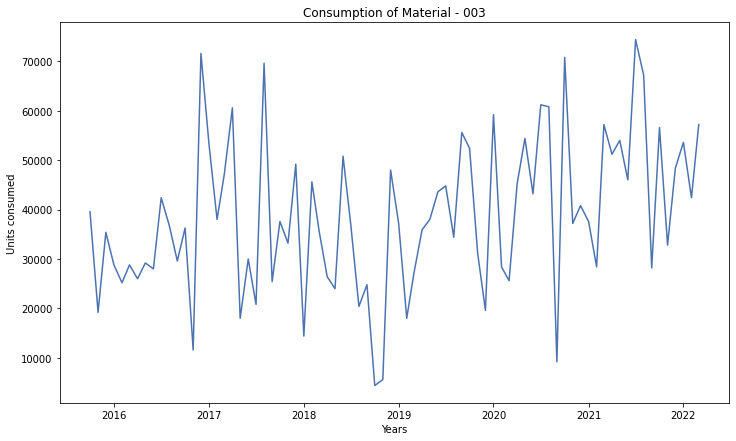

<Figure size 1440x504 with 0 Axes>

In [88]:
# PLOT THE TIME SERIES GRAPH - 

plt.plot(df['ds'], df['y'])

# ADD TITLE AND AXIS NAMES
plt.title('Consumption of Material - 003')
plt.xlabel('Years')
plt.ylabel('Units consumed')
plt.figure(figsize=(20,7))

# SHOW GRAPH
plt.show()

## EXPLORATORY DATA ANALYSIS

#### 1.   YEAR ON YEAR SUPERIMPOSED DATA 

In [6]:
# CREATE FIELDS - YEAR AND MONTH

df['year'] = [d.year for d in df.ds]
df['month'] = [d.strftime('%b') for d in df.ds]
years = df['year'].unique()

# PREP COLORS
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Second argu

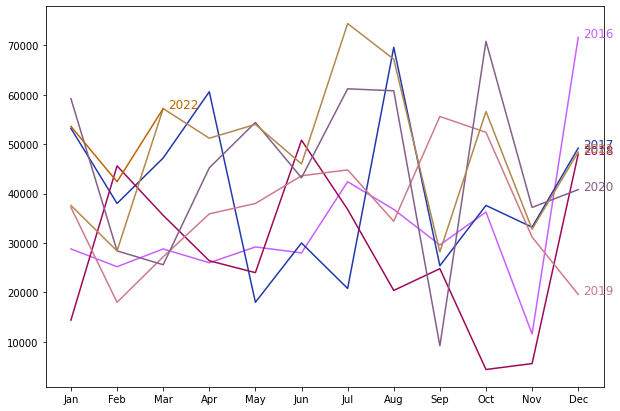

In [7]:
# DRAW PLOT
plt.figure(figsize=(10,7))
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'y', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9,
                 df.loc[df.year==y, 'y'][-1:].values[0], 
                 y, 
                 fontsize=12, color=mycolors[i])


#### BOXPLOTS

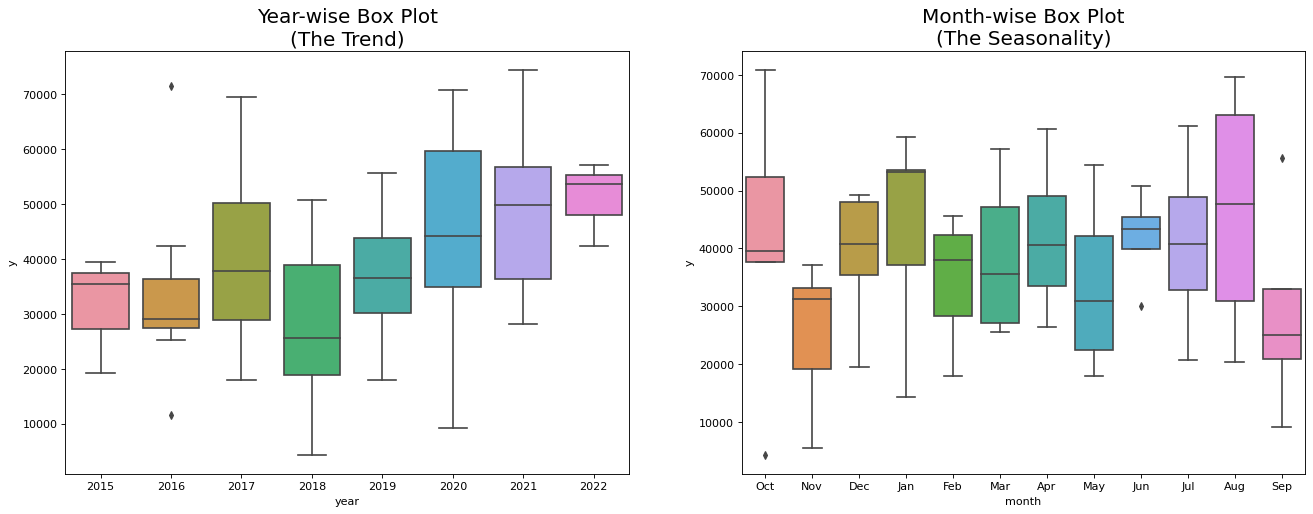

In [8]:
# PLOTTING BOX PLOTS TO VIEW THE SEASONALITY AND TRENDS 

fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='y', data=df, ax=axes[0])
sns.boxplot(x='month', y='y', data=df.loc[~df.year.isin([2016, 2021]), :])

# SET TITLES
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

### TIME SERIES DECOMPOSITION

#### MULTIPLICATIVE DECOMPOSITION

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


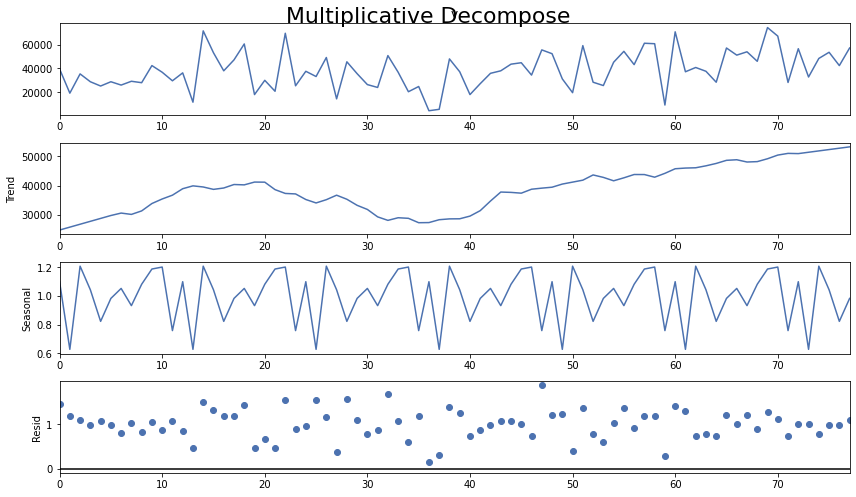

In [9]:
result_mul = seasonal_decompose(df['y'], model='multiplicative',extrapolate_trend='freq',freq=12)

# Plot
plt.rcParams.update({'figure.figsize': (12,7)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
plt.show()

#### ADDITIVE DECOMPOSITION

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


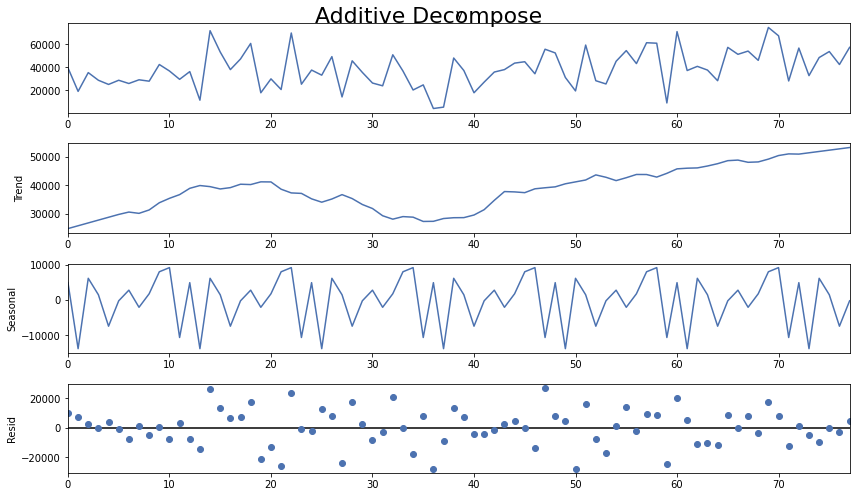

In [10]:
# Additive Decomposition
result_add = seasonal_decompose(df['y'], model='additive', extrapolate_trend='freq',freq=12)

# Plot
plt.rcParams.update({'figure.figsize': (12,7)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

### ACF AND PACF

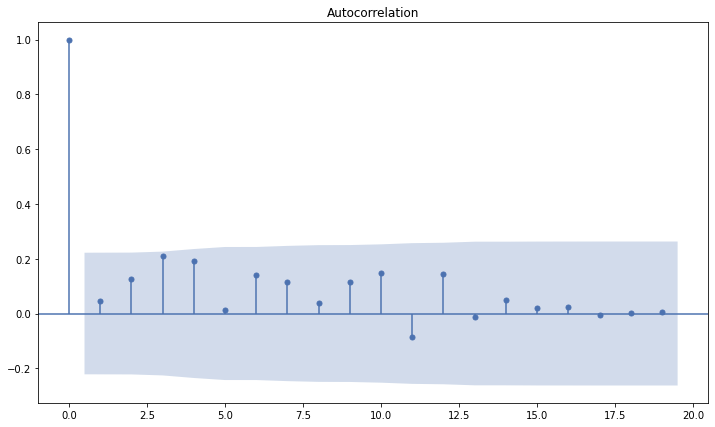

In [11]:
# AUTOCORRELATION

plot_acf(df['y'])
pyplot.show()

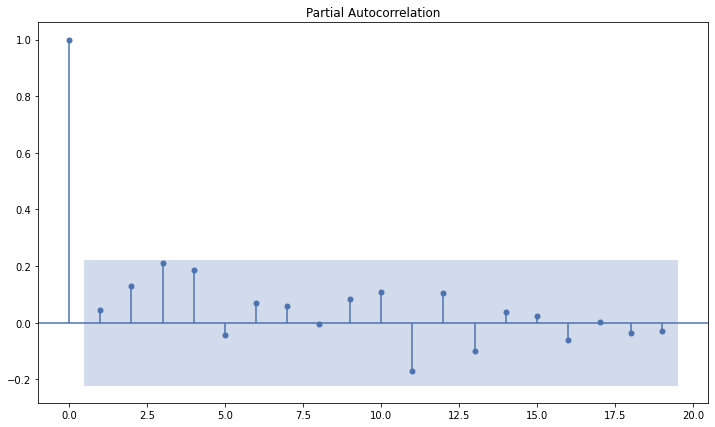

In [12]:
# PARTIAL AUTOCORRELATION

plot_pacf(df['y'])
pyplot.show()

### TESTS FOR STATIONARITY

#### ADF TEST

AUGMENTED DICKY FULLER TEST - 

Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not. It is one of the most commonly used statistical test when it comes to analyzing the stationary of a series.

The hypotheses for the test:

The null hypothesis for this test is that there is a unit root. That is, it is non-stationary.
The alternate hypothesis differs slightly according to which equation you’re using. The basic alternate is that the time series is stationary (or trend-stationary).

In [13]:
interpolated = df.interpolate(method='linear')
interpolated.head()

,ds,y,year,month
0,2015-10-01,39555.0,2015,Oct
1,2015-11-01,19200.0,2015,Nov
2,2015-12-01,35400.0,2015,Dec
3,2016-01-01,28800.0,2016,Jan
4,2016-02-01,25200.0,2016,Feb


In [14]:
from statsmodels.tsa.stattools import adfuller, kpss

adf_result = adfuller(interpolated.y.values, autolag='AIC')
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
for key, value in adf_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -8.205022728970004
p-value: 7.062611570871427e-13
Critial Values:
   1%, -3.518281134660583
Critial Values:
   5%, -2.899878185191432
Critial Values:
   10%, -2.5872229937594873


Since the p-value is greater than 0.05, we do not reject the null hypothesis and conclude that the time series is non-stationary.

## MODELLING

In [96]:
# SPLIT THE DATA INTO TRAINING AND TEST SET

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train = ts[0:72]
test = ts[72:]
print("The size of the training set is :",train.shape)
print("The size of the test set is :",test.shape)

The size of the training set is : (72, 1)
The size of the test set is : (6, 1)


### HOLT-WINTER'S METHOD - EXPONENTIAL SMOOTHING

In [16]:
# HOLT WINTER EXPONENTIAL SMOOTHING

from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_exp_test = ExponentialSmoothing(train)
model_fit_exp_test = model_exp_test.fit()
# make prediction
yhat = model_fit_exp_test.predict(72,78)
print(yhat)

2021-10-01    46955.41193
2021-11-01    46955.41193
2021-12-01    46955.41193
2022-01-01    46955.41193
2022-02-01    46955.41193
2022-03-01    46955.41193
2022-04-01    46955.41193
Freq: MS, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


Since all the predicted values are being overfitted and same, the forecast does not seem accurate enough. We will now use grid search to find the configurations for the paramaters in Exponential smooothing

In [17]:

 
# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
	t,d,s,p,b,r = config
	# define model
	history = array(history)
	model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
	model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = exp_smoothing_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error
 
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    key = str(cfg)
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        try:
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None

    if result is not None:
        print(' > Model [%s] %.3f' % (key, result))
    return (key, result)
 
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores
 
# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
	models = list()
	# define config lists
	t_params = ['add', 'mul', None]
	d_params = [True, False]
	s_params = ['add', 'mul', None]
	p_params = seasonal
	b_params = [True, False]
	r_params = [True, False]
	# create config instances
	for t in t_params:
		for d in d_params:
			for s in s_params:
				for p in p_params:
					for b in b_params:
						for r in r_params:
							cfg = [t,d,s,p,b,r]
							models.append(cfg)
	return models
 
if __name__ == '__main__':
    series = train
    data = series.values
    n_test = 12
    cfg_list = exp_smoothing_configs(seasonal=[0,6,12])
    scores = grid_search(data[:,0], cfg_list, n_test)
    print('done')

for cfg, error in scores[:3]:
		print(cfg, error)

 > Model [['add', True, 'add', 6, False, False]] 16459.581
 > Model [['add', True, 'add', 6, False, True]] 16837.481
 > Model [['add', True, 'add', 6, True, True]] 16997.644
 > Model [['add', True, 'add', 6, True, False]] 16776.175
 > Model [['add', True, 'add', 12, False, True]] 13233.698
 > Model [['add', True, 'add', 12, True, True]] 13110.951
 > Model [['add', True, 'mul', 6, False, True]] 17743.675
 > Model [['add', True, 'mul', 6, True, True]] 17616.228
 > Model [['add', True, 'add', 12, False, False]] 12706.566
 > Model [['add', True, 'add', 12, True, False]] 12750.548
 > Model [['add', True, 'mul', 6, False, False]] 17296.806
 > Model [['add', True, 'mul', 6, True, False]] 17229.909
 > Model [['add', True, None, 0, True, True]] 19828.459
 > Model [['add', True, None, 0, True, False]] 19906.266
 > Model [['add', True, None, 0, False, True]] 19850.371
 > Model [['add', True, None, 0, False, False]] 19770.656
 > Model [['add', True, None, 6, True, True]] 19828.459
 > Model [['add'

Trend: Multiplicative,
Damped: False,
Seasonal: Multiplicative,
Seasonal Periods: 12,
Box-Cox Transform: True,
Remove Bias: True.

                    pred
2021-10-01  46029.539596
2021-11-01  29912.217266
2021-12-01  74971.475098
2022-01-01  63544.135153
2022-02-01  51239.073026
2022-03-01  55117.789574


Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

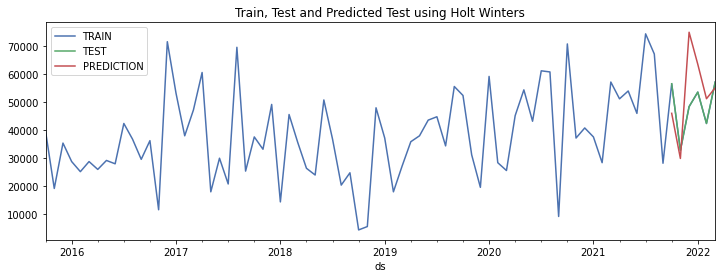

In [98]:
model = ExponentialSmoothing(train,
                             trend ='mul',
                             seasonal='mul',
                             seasonal_periods = 12, 
                             use_boxcox=True,
                             initialization_method="estimated",
                            )
model_fit = model.fit()

# MAKE PREDICTION
yhat_es = model_fit.predict(72,77)
y_pred_es= pd.DataFrame(yhat_es,columns=['pred'])
# ypred = y_pred[0:5]
print(y_pred_es)


# # yhat.plot(legend=True,label='TRAIN')
# test['y'].plot(legend=True,label='TEST',figsize=(6,4))
# y_pred_es['pred'].plot(legend=True,label='PREDICTION')
# plt.title('Train, Test and Predicted Test using Holt Winters')


# yhat.plot(legend=True,label='TRAIN')
ts['y'].plot(legend=True,label='TRAIN',figsize=(12,4))
test['y'].plot(legend=True,label='TEST')
y_pred_es['pred'].plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')

In [118]:
print(model_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                        y   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                    18447382644.651
Optimized:                         True   AIC                           1426.030
Trend:                   Multiplicative   BIC                           1462.456
Seasonal:                Multiplicative   AICC                          1438.935
Seasonal Periods:                    12   Date:                 Tue, 26 Apr 2022
Box-Cox:                           True   Time:                         23:47:44
Box-Cox Coeff.:                 0.75177                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1110714                alpha                 True
smoothing_trend          

In [94]:
test

,ds,yhat
0,2021-10-01,56992.571304
1,2021-11-01,38312.015471
2,2021-12-01,63434.086418
3,2022-01-01,53104.809036
4,2022-02-01,47851.526952
5,2022-03-01,55986.126134


In [91]:
y_pred_es

,pred
2021-10-01,46029.539596
2021-11-01,29912.217266
2021-12-01,74971.475098
2022-01-01,63544.135153
2022-02-01,51239.073026
2022-03-01,55117.789574


In [107]:
print(model_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                        y   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                    18447382644.651
Optimized:                         True   AIC                           1426.030
Trend:                   Multiplicative   BIC                           1462.456
Seasonal:                Multiplicative   AICC                          1438.935
Seasonal Periods:                    12   Date:                 Mon, 25 Apr 2022
Box-Cox:                           True   Time:                         00:23:39
Box-Cox Coeff.:                 0.75177                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1110714                alpha                 True
smoothing_trend          

In [19]:
mean_absolute_percentage_error(test['y'], y_pred_es['pred']).round(3)

0.209

### ARIMA

#### 1. USING AUTO-ARIMA

WE USE AUTO ARIMA FROM PMDARIMA PACKAGE TO FIND THE BEST ARIMA MODEL WITH SEASONALITY. WE DO NOT PREFER ARIMA MODEL SINCE THE TIME SERIES IS NON-STATIONARY TIME SERIES.

In [20]:
model_aa = auto_arima(train, 
                            start_p=0, 
                            start_q=0,
                            max_p=5, 
                            max_q=5, 
                            m=12,
                            start_P=0, 
                            seasonal=True,
                            trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True,
                            random_state = 20, 
                            n_fits=20)
print(model_aa.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1627.130, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1626.671, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1606.980, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1585.744, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1624.682, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1580.544, Time=0.11 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1586.890, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1583.137, Time=0.67 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1584.560, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=1588.986, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1605.390, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1584.253, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=1580.805, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12] intercept
Total fit time: 1.766 seconds
1580.544

            predicted_mean
2021-10-01    48269.384286
2021-11-01    48269.384286
2021-12-01    48269.384286
2022-01-01    48269.384286
2022-02-01    48269.384286
2022-03-01    48269.384286


Text(0.5, 1.0, 'Train, Test and Predicted Test using Auto Arima')

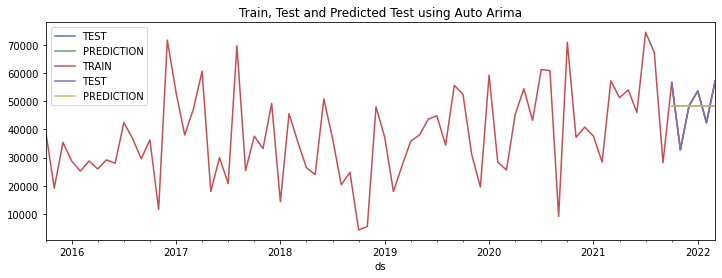

In [99]:
model_aa_ = SARIMAX(train, 
                order=(0,1,1), 
                seasonal_order=(0,0,0,12), 
               )
model_aa_fit=model_aa_.fit()

yhat = model_aa_fit.predict(start=len(train), end=(len(train)+5))
y_pred_aa= pd.DataFrame(yhat)
print(y_pred_aa)

# yhat.plot(legend=True,label='TRAIN')
test['y'].plot(legend=True,label='TEST',figsize=(6,4))
y_pred_aa['predicted_mean'].plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Auto Arima')

# yhat.plot(legend=True,label='TRAIN')
ts['y'].plot(legend=True,label='TRAIN',figsize=(12,4))
test['y'].plot(legend=True,label='TEST')
y_pred_aa['predicted_mean'].plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Auto Arima')

In [108]:
print(model_aa_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   72
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -788.403
Date:                Mon, 25 Apr 2022   AIC                           1580.805
Time:                        00:24:41   BIC                           1585.330
Sample:                    10-01-2015   HQIC                          1582.605
                         - 09-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8726      0.058    -15.000      0.000      -0.987      -0.759
sigma2      2.685e+08   5.11e-12   5.25e+19      0.000    2.69e+08    2.69e+08
Ljung-Box (L1) (Q):                   1.35   Jarque-

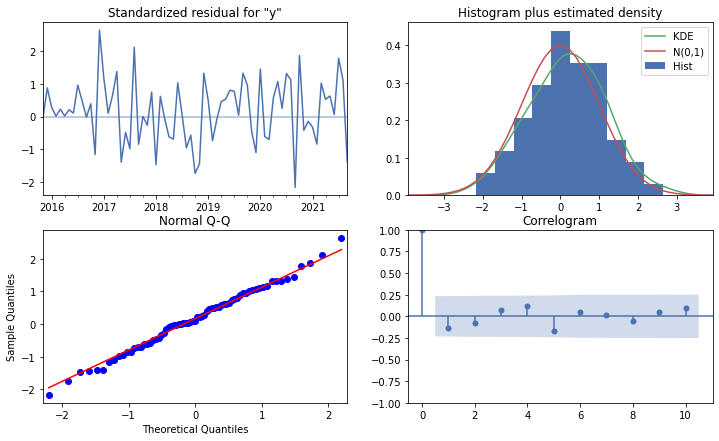

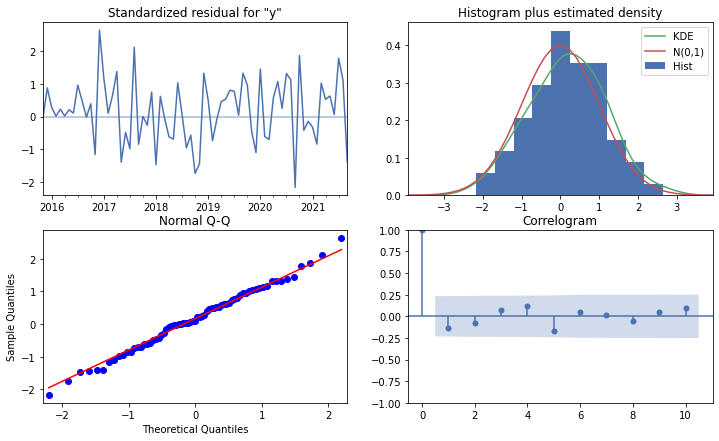

In [103]:
model_aa_fit.plot_diagnostics()

In [23]:
mean_absolute_percentage_error(test['y'], y_pred_aa['predicted_mean']).round(3)

# mean_absolute_percentage_error(test['y'], y_pred_aa['pred']).round(3)

0.169

### 2. SARIMAX

#### GRIDSEARCH FOR HYPERPARAMETERS FOR SARIMAX

In [24]:
import warnings
warnings.filterwarnings('ignore')
# Grid Search
p = d = q = range(0,3) # p, d, and q can be either 0, 1, or 2
pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q 
p2 = d2 = q2 = range(0, 2) # second set of p's, d's, and q's for seasonal parameters
pdq2 = list(itertools.product(p2,d2,q2)) # similar to code above but for seasonal parameters
s = 12 # here I use twelve but the number here is representative of the periodicity of the seasonal cycle
pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2]
combs = {}
aics = []
# Grid Search Continued
for combination in pdq:
    for seasonal_combination in pdqs2:
        try:
            model = sm.tsa.statespace.SARIMAX(train, order=combination, seasonal_order=seasonal_combination,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            model = model.fit(disp=False)
            combs.update({model.aic : [combination, seasonal_combination]})
            aics.append(model.aic)
            
        except:
            continue
            
best_aic = min(aics)

print('best aic is: ', round(best_aic, 3))
print(40*'==')
print ('ARIMA parameters: ', '\n', 'AR: ', combs[best_aic][0][0], '\n', 'I: ',combs[best_aic][0][1], '\n', 'MA: ',combs[best_aic][0][2])
print('Seasonal parameters:', combs[best_aic][1])

best aic is:  1333.344
ARIMA parameters:  
 AR:  0 
 I:  2 
 MA:  2
Seasonal parameters: (0, 1, 0, 12)


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   72
Model:             SARIMAX(0, 2, 2)x(0, 1, [], 12)   Log Likelihood                -663.672
Date:                             Mon, 25 Apr 2022   AIC                           1333.344
Time:                                     00:22:08   BIC                           1339.525
Sample:                                 10-01-2015   HQIC                          1335.751
                                      - 09-01-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.7974      0.066    -27.418      0.000      -1.926      -1.669
ma.L2          0.8087      

Text(0.5, 1.0, 'Train, Test and Predicted Test using SARIMAX')

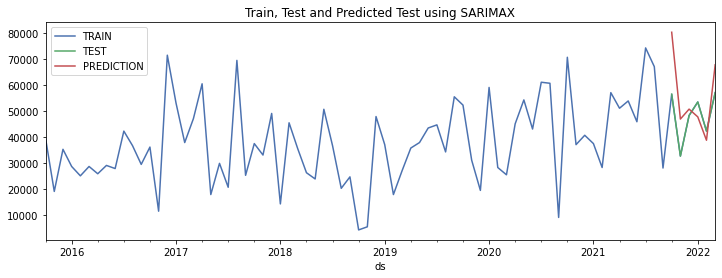

In [105]:
model_sarimax = SARIMAX(train, 
                order=(0,2,2), 
                seasonal_order=(0,1,0,12), 
#                 trend='c')
               )
results_sarimax=model_sarimax.fit()

print(results_sarimax.summary())

yhat_sx = results_sarimax.predict(start=len(train), end=(len(train)+5))
y_pred_sx= pd.DataFrame(yhat_sx)
print (y_pred_sx)

# yhat.plot(legend=True,label='TRAIN')
ts['y'].plot(legend=True,label='TRAIN',figsize=(12,4))
test['y'].plot(legend=True,label='TEST')
y_pred_sx['predicted_mean'].plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using SARIMAX')

In [106]:
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   72
Model:             SARIMAX(0, 2, 2)x(0, 1, [], 12)   Log Likelihood                -663.672
Date:                             Mon, 25 Apr 2022   AIC                           1333.344
Time:                                     00:22:53   BIC                           1339.525
Sample:                                 10-01-2015   HQIC                          1335.751
                                      - 09-01-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.7974      0.066    -27.418      0.000      -1.926      -1.669
ma.L2          0.8087      0.068     11.910      0.000       0.676       0.942
sigma2      5.037e+08   5.42e-12    9.3e+19      0.000    5.04e+08    5.04e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):                 3.10
Prob(Q):                              0.52   Prob(JB):                         0.21
Heteroskedasticity (H):               0.78   Skew:                            -0.56
Prob(H) (two-sided):                  0.59   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.78e+36. Standard errors may be unstable.
"""

In [26]:
mean_absolute_percentage_error(test['y'], y_pred_sx['predicted_mean'])

0.2137929727392902

In [27]:
mean_absolute_percentage_error(test['y'], y_pred_sx['predicted_mean']).round(3)

0.214

### 3. FBPROPHET

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


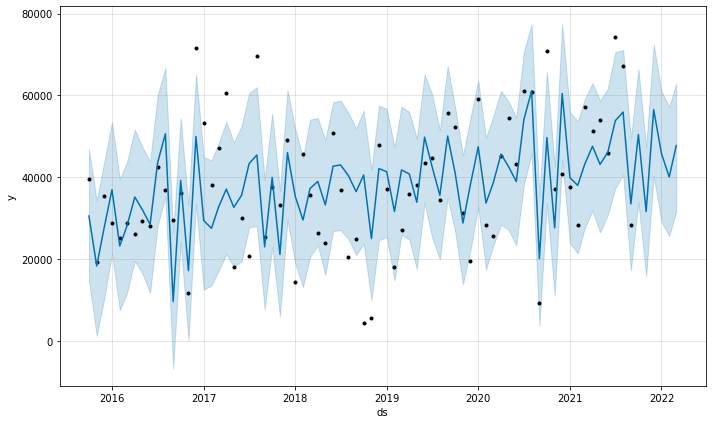

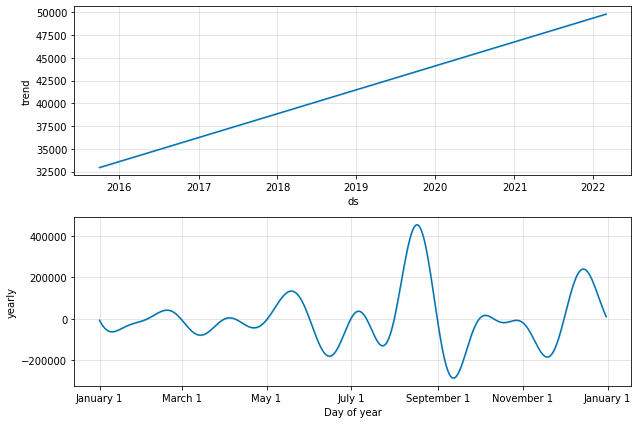

In [28]:
df_train = df[0:72]
df_test = df[72:]

cutoffs = pd.date_range(start='2017-01-01', end='2020-06-01', freq='2MS') 
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

m= Prophet()
m.fit(df_train)
future = m.make_future_dataframe(periods=6,freq = 'MS') 
forecast = m.predict(future)

fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)


In [112]:
y_pred_fpb = forecast[['ds','yhat']].tail(6)
y_pred_fpbp = y_pred_fpb.set_index('ds')

+---------------------+--------------+-----------+
|   FORECASTED_DATE   | PROPHET_GRID | TEST_DATA |
+---------------------+--------------+-----------+
| 2021-10-01 00:00:00 |   59481.0    |  56600.0  |
| 2021-11-01 00:00:00 |   32837.0    |  32800.0  |
| 2021-12-01 00:00:00 |   62782.0    |  48400.0  |
| 2022-01-01 00:00:00 |   51813.0    |  53600.0  |
| 2022-02-01 00:00:00 |   42507.0    |  42400.0  |
| 2022-03-01 00:00:00 |   55478.0    |  57200.0  |
+---------------------+--------------+-----------+


KeyError: 'PROPHET_BASE'

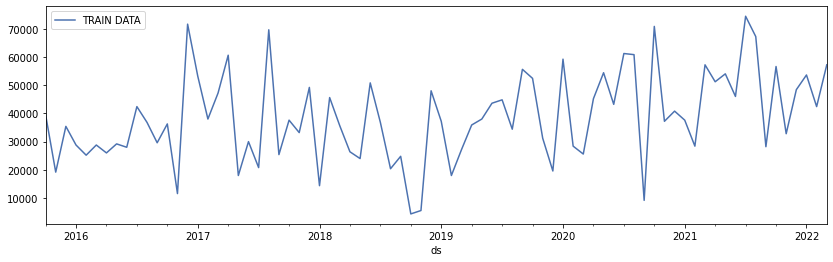

In [124]:
y_pred = pd.DataFrame()
y = pd.DataFrame()
y_pred['FORECASTED_DATE'] = df_test['ds'].values
# y_pred['EXP_SMOOTHING'] = y_pred_es['pred'].values.round(0)
# y_pred['AUTO_ARIMA'] = y_pred_aa['predicted_mean'].values.round(0)
# y_pred['SARIMAX'] = y_pred_sx['predicted_mean'].values.round(0)
# y_pred['PROPHET_BASE'] = y_pred_fpb['yhat'].values.round(0)
y_pred['PROPHET_GRID'] = y_pred_fp['yhat'].values.round(0)

y_pred=y_pred.set_index('FORECASTED_DATE')
y=y_pred
y['TEST_DATA'] = df_test['y'].values
print(tabulate(y, headers = 'keys', tablefmt = 'pretty'))

# PLOT TRAINING DATA
ts['y'].plot(legend=True,label='TRAIN DATA',figsize=(14,4))

# PLOT PREDICTED DATA

y['PROPHET_BASE'].plot(legend=True,label='PROPHET_BASE')
y['TEST_DATA'].plot(legend=True,label='TEST DATA')


print(plt.title('Train, Test and Predicted Test for Material - C'))

# dataframe = pd.DataFrame(dict)
# dataframe['Accuracy %'] = ((1-dataframe['MAPE'])*100).round(2)
# final_df=dataframe.sort_values(by=['Accuracy %'],ascending=False).reset_index(drop=True)
  
# # displaying the DataFrame
# print(tabulate(final_df, headers = 'keys', tablefmt = 'pretty'))

# min_mape = final_df['MAPE'].min()
# modelname=final_df[final_df['MAPE']==min_mape]['Model']
# # modelname
# print("model name is  ",modelname)

Text(0.5, 1.0, 'Train, Test and Predicted Test using FB Prophet - Base model')

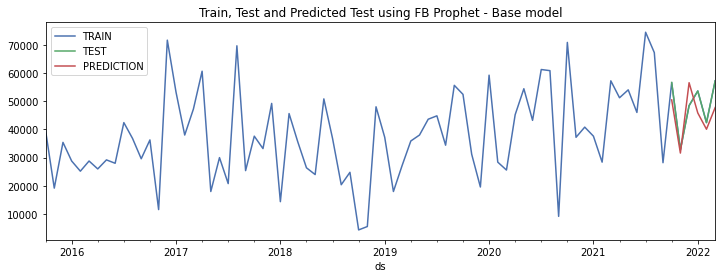

In [115]:
# yhat.plot(legend=True,label='TRAIN')
ts['y'].plot(legend=True,label='TRAIN',figsize=(12,4))
test['y'].plot(legend=True,label='TEST')
y_pred_fpbp['yhat'].plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using FB Prophet - Base model')

In [109]:
mean_absolute_percentage_error(test['y'], y_pred_fpb['yhat']).round(3)

0.113

In [30]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
#               'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

import random
strt='2015-10-01'
end='2022-03-01'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
#                          holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
#                          weekly_seasonality=True,
#                          daily_seasonality = True,
                         yearly_seasonality = True,
#                          holidays=holiday, 
                         interval_width=0.95)
#     train_model.add_country_holidays(country_name='US')
    train_model.fit(df_train)
    
    train_forecast = train_model.make_future_dataframe(periods=6, freq='MS',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = df[(df['ds']>strt) & (df['ds']<=end)]
    MAPE = mean_absolute_percentage_error((Actual['y'].tail(6)),abs(test['yhat']))
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Total Possible Models 30
{'changepoint_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.12124532022032782
{'changepoint_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.11215729319836039
{'changepoint_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.12124532022032782
{'changepoint_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.11215729319836039
{'changepoint_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.12124532022032782
{'changepoint_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.11215729319836039
{'changepoint_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.07580558593403684
{'changepoint_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.09574153302485232
{'changepoint_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.07580558593403684
{'changepoint_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.09574153302485232
{'changepoint_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.07580558593403684
{'changepoint_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.09574153302485232
{'changepoint_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.06918878077928921
{'changepoint_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.09982444359677793
{'changepoint_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.06918878077928921
{'changepoint_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.09982444359677793
{'changepoint_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.06918878077928921
{'changepoint_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.09982444359677793
{'changepoint_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.07383789163352363
{'changepoint_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.10230346429277269
{'changepoint_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.07383789163352363
{'changepoint_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.10230346429277269
{'changepoint_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.07383789163352363
{'changepoint_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.10230346429277269
{'changepoint_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.08797080052757822
{'changepoint_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.10744011974561847
{'changepoint_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.08797080052757822
{'changepoint_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.10744011974561847
{'changepoint_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.08797080052757822
{'changepoint_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.10744011974561847


In [31]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters['Parameters'][1]

{'changepoint_prior_scale': 0.3,
 'n_changepoints': 200,
 'seasonality_mode': 'multiplicative'}

In [35]:
final_model = Prophet(
                      changepoint_prior_scale= 0.3,
                      n_changepoints = 200,
                      seasonality_mode = 'multiplicative',
                      yearly_seasonality = True
                      )
final_model.fit(df_train)

future = final_model.make_future_dataframe(periods=6, freq='MS')
y_pred_fp = final_model.predict(future)
y_pred_fp=y_pred_fp[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

MAPE = mean_absolute_percentage_error((y_pred_fp['yhat'].tail(6)),(df_test['y']))

mean_absolute_percentage_error(df_test['y'],y_pred_fp['yhat'].tail(6))



INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 56.


0.06918878077928921

In [117]:
y_pred_fp

,ds,yhat,yhat_lower,yhat_upper
72,2021-10-01,59481.429099,44668.528296,74674.605876
73,2021-11-01,32836.500374,18001.712645,47535.973204
74,2021-12-01,62781.789096,49116.069284,77846.546700
75,2022-01-01,51813.209281,36728.784312,67280.523778
76,2022-02-01,42507.073729,27281.886585,58093.076113
77,2022-03-01,55477.945224,40041.192368,71262.099223


Text(0.5, 1.0, 'Train, Test and Predicted Test using Prophet')

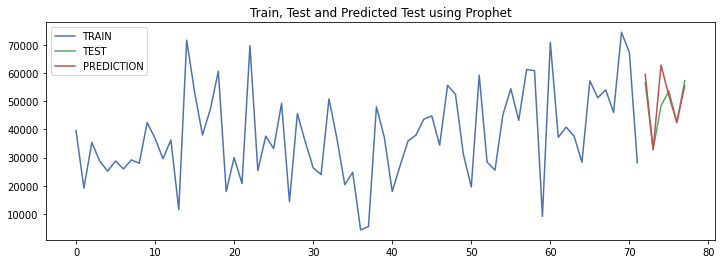

In [36]:
# yhat.plot(legend=True,label='TRAIN')
df_train['y'].plot(legend=True,label='TRAIN',figsize=(12,4))
df_test['y'].plot(legend=True,label='TEST')
y_pred_fp['yhat'].plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Prophet')

In [ ]:
mape()

### RESULTS

+---------------------+---------------+------------+---------+--------------+--------------+-----------+
|   FORECASTED_DATE   | EXP_SMOOTHING | AUTO_ARIMA | SARIMAX | PROPHET_BASE | PROPHET_GRID | TEST_DATA |
+---------------------+---------------+------------+---------+--------------+--------------+-----------+
| 2021-10-01 00:00:00 |    46030.0    |  48269.0   | 80427.0 |   50447.0    |   59481.0    |  56600.0  |
| 2021-11-01 00:00:00 |    29912.0    |  48269.0   | 47043.0 |   31612.0    |   32837.0    |  32800.0  |
| 2021-12-01 00:00:00 |    74971.0    |  48269.0   | 50859.0 |   56534.0    |   62782.0    |  48400.0  |
| 2022-01-01 00:00:00 |    63544.0    |  48269.0   | 47875.0 |   45821.0    |   51813.0    |  53600.0  |
| 2022-02-01 00:00:00 |    51239.0    |  48269.0   | 38892.0 |   40053.0    |   42507.0    |  42400.0  |
| 2022-03-01 00:00:00 |    55118.0    |  48269.0   | 67908.0 |   47749.0    |   55478.0    |  57200.0  |
+---------------------+---------------+------------+---

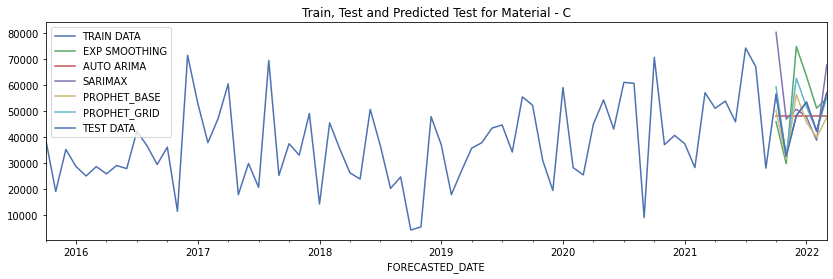

In [125]:
y_pred = pd.DataFrame()
y = pd.DataFrame()
y_pred['FORECASTED_DATE'] = df_test['ds'].values
y_pred['EXP_SMOOTHING'] = y_pred_es['pred'].values.round(0)
y_pred['AUTO_ARIMA'] = y_pred_aa['predicted_mean'].values.round(0)
y_pred['SARIMAX'] = y_pred_sx['predicted_mean'].values.round(0)
y_pred['PROPHET_BASE'] = y_pred_fpb['yhat'].values.round(0)
y_pred['PROPHET_GRID'] = y_pred_fp['yhat'].values.round(0)

y_pred=y_pred.set_index('FORECASTED_DATE')
y=y_pred
y['TEST_DATA'] = df_test['y'].values
print(tabulate(y, headers = 'keys', tablefmt = 'pretty'))

# PLOT TRAINING DATA
ts['y'].plot(legend=True,label='TRAIN DATA',figsize=(14,4))

# PLOT PREDICTED DATA
y['EXP_SMOOTHING'].plot(legend=True,label='EXP SMOOTHING')
y['AUTO_ARIMA'].plot(legend=True,label='AUTO ARIMA')
y['SARIMAX'].plot(legend=True,label='SARIMAX')
y['PROPHET_BASE'].plot(legend=True,label='PROPHET_BASE')
y['PROPHET_GRID'].plot(legend=True,label='PROPHET_GRID')
y['TEST_DATA'].plot(legend=True,label='TEST DATA')


print(plt.title('Train, Test and Predicted Test for Material - C'))

mape_prof_grid = mean_absolute_percentage_error(y['TEST_DATA'],y['PROPHET_GRID']).round(3)
mape_prof_base = mean_absolute_percentage_error(y['TEST_DATA'],y['PROPHET_BASE']).round(3)
mape_sarimax = mean_absolute_percentage_error(y['TEST_DATA'],y['SARIMAX']).round(3)
mape_exp = mean_absolute_percentage_error(y['TEST_DATA'],y['EXP_SMOOTHING']).round(3)
mape_aa = mean_absolute_percentage_error(y['TEST_DATA'],y['AUTO_ARIMA']).round(3)

# creating a DataFrame
dict = {'Model' : ['Holt Winters Exponential Smoothing',
                   'Sarimax',
                   'Auto Arima',
                   'Prophet - basic model', 
                   'Prophet - with tuning'],
        'MAPE' : [mape_exp,
                  mape_sarimax,
                  mape_aa,
                  mape_prof_base,
                  mape_prof_grid]}

dataframe = pd.DataFrame(dict)
dataframe['Accuracy %'] = ((1-dataframe['MAPE'])*100).round(2)
final_df=dataframe.sort_values(by=['Accuracy %'],ascending=False).reset_index(drop=True)
  
# displaying the DataFrame
print(tabulate(final_df, headers = 'keys', tablefmt = 'pretty'))

min_mape = final_df['MAPE'].min()
modelname=final_df[final_df['MAPE']==min_mape]['Model']
# modelname
print("model name is  ",modelname)